<a href="https://colab.research.google.com/github/jorgeerodriguez/FinOps_AWS/blob/main/TimeSeries_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/GitHub/FinOps_AWS"
fnames = os.listdir(path)
for names in fnames:
  print(names)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/GitHub/FinOps_AWS'

In [ ]:
#!pip install common.utils

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from common.utils import load_data, mape
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [4]:
f = path + ("/combined.csv")
f = "combined.csv"
combined_df = pd.read_csv(f)
df_dl_p =combined_df.copy()
df_dl_p['Date_str'] = df_dl_p['Year'].apply(lambda x: str(x)) + "-" + df_dl_p['Month No'].apply(lambda x: str(x)) + "-01"
df_dl_p['Date'] = pd.to_datetime(df_dl_p['Date_str'])
df_dl_p.set_index('Date')
df_dl_p.index = pd.to_datetime(df_dl_p.index)
df_dl_p = df_dl_p.groupby(['Date']).agg(Cost=('Cost','sum'))

In [5]:
df_dl_p

,Cost
Date,
2021-10-01,3.794357e+05
2021-11-01,4.499119e+05
2021-12-01,4.646831e+05
2022-01-01,4.806844e+05
2022-02-01,4.958688e+05
2022-03-01,5.622309e+05
2022-04-01,6.468500e+05
2022-05-01,1.344622e+06
2022-06-01,7.066702e+05


In [6]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [7]:
ts_data_load = df_dl_p.copy()
ts_data_load.head()

,Cost
Date,
2021-10-01,"379,435.68"
2021-11-01,"449,911.87"
2021-12-01,"464,683.13"
2022-01-01,"480,684.44"
2022-02-01,"495,868.77"


In [8]:
valid_st_data_load = "2023-01-01 00:00:00" # Y-M-D
test_st_data_load = "2024-01-01 00:00:00"

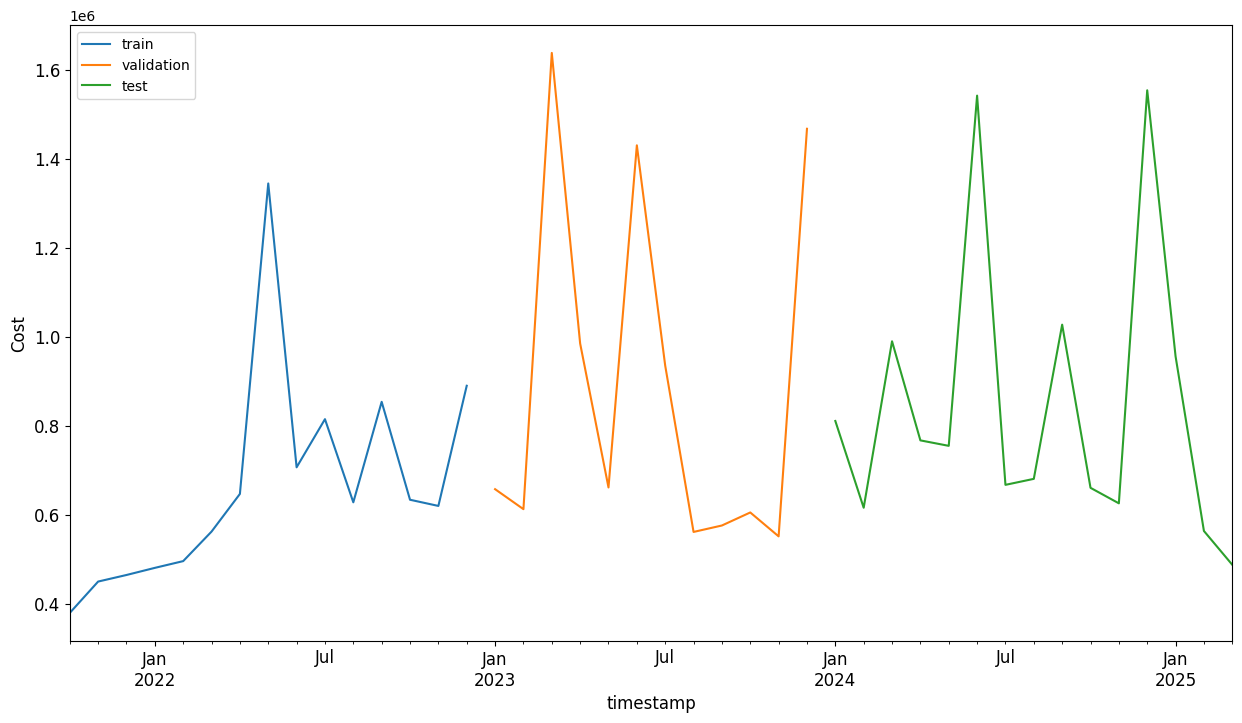

In [9]:
ts_data_load[ts_data_load.index < valid_st_data_load][["Cost"]].rename(columns={"Cost": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["Cost"]
    ].rename(columns={"Cost": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["Cost"]].rename(columns={"Cost": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.show()

In [ ]:
T = 6
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][["Cost"]]

scaler = MinMaxScaler()
train["Cost"] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["Cost"].shift(-1)
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["Cost"].shift(T - t)
y_col = "y_t+1"
X_cols = ["Cost_t-5", "Cost_t-4", "Cost_t-3", "Cost_t-2", "Cost_t-1", "Cost_t"]
train_shifted.columns = ["Cost_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head()

,Cost_original,y_t+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t
Date,,,,,,,,
2022-03-01,0.19,0.28,0.00,0.07,0.09,0.10,0.12,0.19
2022-04-01,0.28,1.00,0.07,0.09,0.10,0.12,0.19,0.28
2022-05-01,1.00,0.34,0.09,0.10,0.12,0.19,0.28,1.00
2022-06-01,0.34,0.45,0.10,0.12,0.19,0.28,1.00,0.34
2022-07-01,0.45,0.26,0.12,0.19,0.28,1.00,0.34,0.45


In [ ]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [ ]:
T

6

In [ ]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [ ]:
y_train.shape

(9,)

In [ ]:
y_train[:3]

array([0.28, 1.  , 0.34])

In [ ]:
X_train.shape

(9, 6, 1)

In [ ]:
train_shifted.head(3)

,Cost_original,y_t+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t
Date,,,,,,,,
2022-03-01,0.19,0.28,0.00,0.07,0.09,0.10,0.12,0.19
2022-04-01,0.28,1.00,0.07,0.09,0.10,0.12,0.19,0.28
2022-05-01,1.00,0.34,0.09,0.10,0.12,0.19,0.28,1.00


In [ ]:
#look_back_dt = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    hours=T - 1
#)
#valid = ts_data_load.copy()[(ts_data_load.index >= look_back_dt) & (ts_data_load.index < test_st_data_load)][
#    ["Cost"]
#]

valid = ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["Cost"]
    ]

valid["Cost"] = scaler.transform(valid)

valid_shifted = valid.copy()
valid_shifted["y+1"] = valid_shifted["Cost"].shift(-1)
for t in range(1, T + 1):
    valid_shifted["Cost_t-" + str(T - t)] = valid_shifted["Cost"].shift(T - t)

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head()

,Cost,y+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t-0
Date,,,,,,,,
2023-06-01,1.09,0.58,0.29,0.24,1.30,0.63,0.29,1.09
2023-07-01,0.58,0.19,0.24,1.30,0.63,0.29,1.09,0.58
2023-08-01,0.19,0.20,1.30,0.63,0.29,1.09,0.58,0.19
2023-09-01,0.20,0.23,0.63,0.29,1.09,0.58,0.19,0.20
2023-10-01,0.23,0.18,0.29,1.09,0.58,0.19,0.20,0.23


In [ ]:
y_valid = valid_shifted["y+1"].to_numpy()
X_valid = valid_shifted[["Cost_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [ ]:
y_valid.shape

(6,)

In [ ]:
y_valid[:3]

array([0.58, 0.19, 0.2 ])

In [ ]:
X_valid.shape

(6, 6, 1)

In [ ]:
X_valid[:3]

array([[[0.29],
        [0.24],
        [1.3 ],
        [0.63],
        [0.29],
        [1.09]],

       [[0.24],
        [1.3 ],
        [0.63],
        [0.29],
        [1.09],
        [0.58]],

       [[1.3 ],
        [0.63],
        [0.29],
        [1.09],
        [0.58],
        [0.19]]])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = (
    200
)

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer="RMSprop", loss="mse")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 5)                   │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [ ]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2700 - val_loss: 0.3304
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2525 - val_loss: 0.3171
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2406 - val_loss: 0.3066
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2310 - val_loss: 0.2976
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2229 - val_loss: 0.2896
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2157 - val_loss: 0.2824
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2092 - val_loss: 0.2758
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2031 - val_loss: 0.2697
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1975 - val_loss: 0.2639
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1923 - val_loss: 0.2585
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1873 - val_loss: 0.2534
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1826 - 

In [ ]:
look_back_dt = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)

test = ts_data_load.copy()[test_st_data_load:][["Cost"]]

test["Cost"] = scaler.transform(test)

test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["Cost"].shift(-1)
for t in range(1, T + 1):
    test_shifted["Cost_t-" + str(T - t)] = test_shifted["Cost"].shift(T - t)

test_shifted = test_shifted.dropna(how="any")

y_test = test_shifted["y_t+1"].to_numpy()
X_test = test_shifted[["Cost_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [ ]:
test_shifted

,Cost,y_t+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t-0
Date,,,,,,,,
2024-06-01,1.20,0.30,0.45,0.24,0.63,0.40,0.39,1.20
2024-07-01,0.30,0.31,0.24,0.63,0.40,0.39,1.20,0.30
2024-08-01,0.31,0.67,0.63,0.40,0.39,1.20,0.30,0.31
2024-09-01,0.67,0.29,0.40,0.39,1.20,0.30,0.31,0.67
2024-10-01,0.29,0.26,0.39,1.20,0.30,0.31,0.67,0.29
2024-11-01,0.26,1.22,1.20,0.30,0.31,0.67,0.29,0.26
2024-12-01,1.22,0.60,0.30,0.31,0.67,0.29,0.26,1.22
2025-01-01,0.60,0.19,0.31,0.67,0.29,0.26,1.22,0.60
2025-02-01,0.19,-0.19,0.67,0.29,0.26,1.22,0.60,0.19


In [ ]:
y_test

array([ 0.3 ,  0.31,  0.67,  0.29,  0.26,  1.22,  0.6 ,  0.19, -0.19])

In [ ]:
X_test.shape

(9, 6, 1)

In [ ]:
ts_predictions = model.predict(X_test)
ts_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


array([[0.32],
       [0.34],
       [0.35],
       [0.35],
       [0.37],
       [0.39],
       [0.34],
       [0.33],
       [0.34]], dtype=float32)

In [ ]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2024-06-01,t+1,"687,991.86","667,258.51"
1,2024-07-01,t+1,"705,340.64","680,725.63"
2,2024-08-01,t+1,"717,964.36","1,027,314.59"
3,2024-09-01,t+1,"714,975.12","660,593.27"
4,2024-10-01,t+1,"732,995.42","625,740.62"


In [ ]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [ ]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.4820590227204996

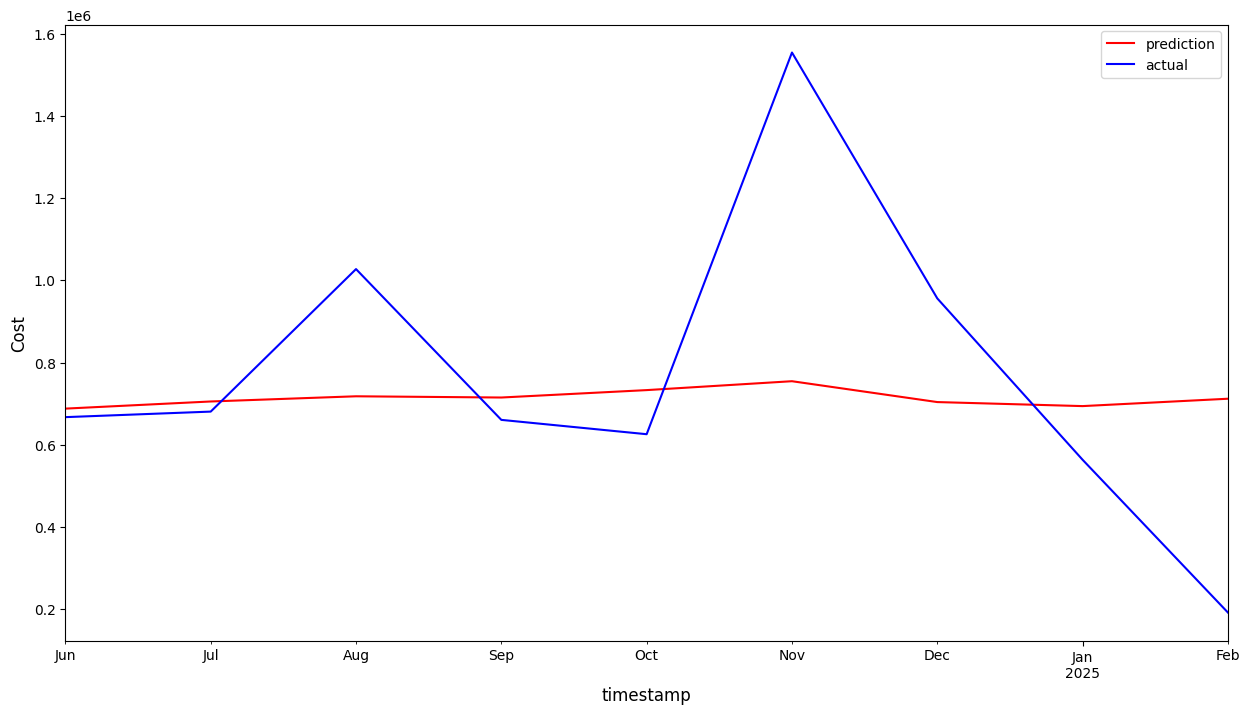

In [ ]:
ev_ts_data[ev_ts_data.timestamp < "2026-01-01"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.show()

# Time Series Forcasting Using Deep Learning with PyTorch


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import yfinance as yf

In [11]:
# combined_df = pd.read_csv("combined.csv")
f = path + ("/combined.csv")
combined_df = pd.read_csv(f)
df_dl_p =combined_df.copy()
df_dl_p['Date_str'] = df_dl_p['Year'].apply(lambda x: str(x)) + "-" + df_dl_p['Month No'].apply(lambda x: str(x)) + "-01"
df_dl_p['Date'] = pd.to_datetime(df_dl_p['Date_str'])
df_dl_p.set_index('Date')
df_dl_p.index = pd.to_datetime(df_dl_p.index)
df_dl_p = df_dl_p.groupby(['Date']).agg(Cost=('Cost','sum'))

In [11]:
df_dl_p['Cost'].values

array([ 379435.68,  449911.87,  464683.13,  480684.44,  495868.77,
        562230.93,  646850.02, 1344621.56,  706670.17,  814895.03,
        628009.12,  853861.66,  633772.29,  619883.31,  889948.35,
        657555.15,  612616.38, 1637977.72,  984951.62,  661406.92,
       1430313.23,  935199.45,  561431.97,  575917.79,  605203.32,
        551499.41, 1467498.9 ,  810804.83,  615822.81,  989912.92,
        767211.24,  754922.18, 1542013.75,  667258.51,  680725.63,
       1027314.59,  660593.27,  625740.62, 1554001.94,  956054.63,
        563596.49,  487636.75])

In [12]:
#cost = df_dl_p['Cost'].values.tolist()
x = np.array(df_dl_p['Cost'].values)
np.concatenate((x, x, x, x), axis=0)
cost = np.concatenate((x, x, x, x, x, x, x, x, x, x), axis=0).tolist()
print(len(cost))
train , test = cost[:len(cost)-12], cost[len(cost)-12:]
print(len(train), len(test))
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.forecast(14)
for x in range(len(pred)):
  if x < len(test):
    print('predicted=%f, expected=%f' % (pred[x], test[x]))
  else:
    print('predicted=%f,' % (pred[x]))





420
408 12
predicted=695715.077474, expected=767211.239278
predicted=798036.720774, expected=754922.179877
predicted=1181921.462869, expected=1542013.753067
predicted=810716.568373, expected=667258.506338
predicted=626155.984956, expected=680725.630970
predicted=934963.443139, expected=1027314.586506
predicted=711743.754879, expected=660593.272434
predicted=800905.571634, expected=625740.615532
predicted=1171268.852916, expected=1554001.935316
predicted=783932.043431, expected=956054.632754
predicted=631929.965286, expected=563596.494212
predicted=918346.581418, expected=487636.747875
predicted=695715.077474,
predicted=798036.720774,


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


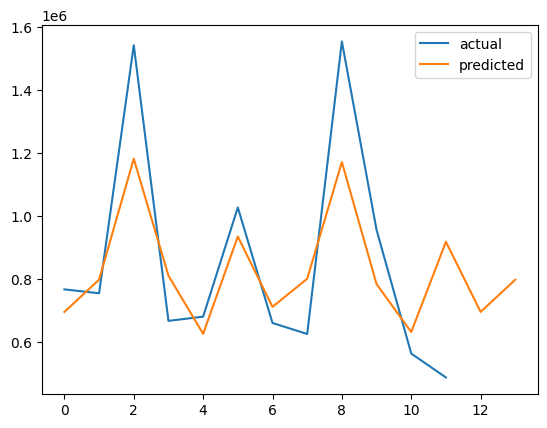

In [13]:
plt.plot(test, label='actual')
plt.plot(pred, label='predicted')
plt.legend()

In [14]:
import torch


In [15]:
def get_function(x1_val = 0, x2_val = 0, x3_val = 0, x4_val = 0):
  # variables
  x1 = torch.tensor(x1_val, requires_grad=True, dtype=torch.float32)
  x2 = torch.tensor(x2_val, requires_grad=True, dtype=torch.float32)
  x3 = torch.tensor(x3_val, requires_grad=True, dtype=torch.float32)
  x4 = torch.tensor(x4_val, requires_grad=True, dtype=torch.float32)

  # function
  p1 = x1.pow(3)
  m1 = p1 * x2
  m2 = x3 * x4
  f = m1 + m2
  vars = {'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4}
  return f, vars


In [16]:
if __name__ == '__main__':
  f, vars = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
  print(f.item())

47.0


In [14]:
! pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [17]:
from torchviz import make_dot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



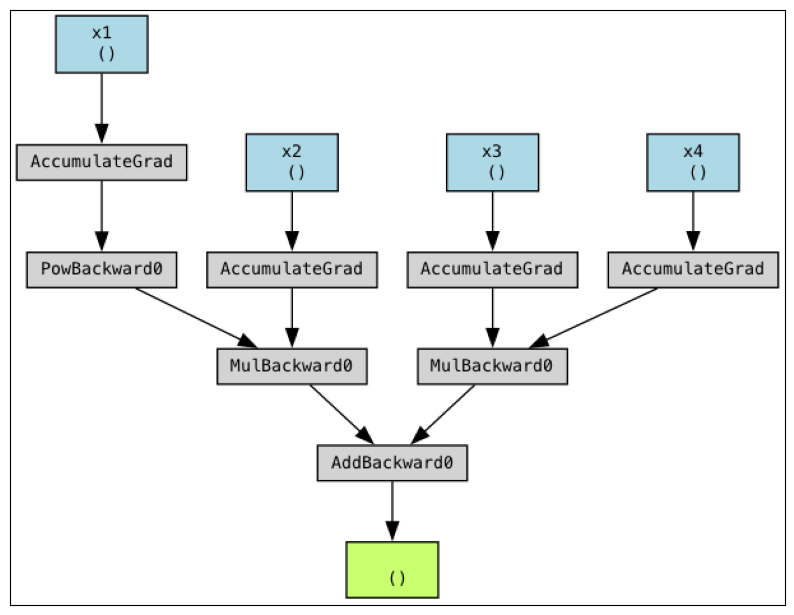

In [18]:
f, params = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
make_dot(f, params=params).render("function", format="png")
img = mpimg.imread('function.png')
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(img)
plt.show()


In [19]:
from torch.autograd import grad


In [20]:
f, params = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
df_dx1 = grad(f, params['x1'])
#df_dx2 = grad(f, params['x2'])
print(df_dx1)
#print(df_dx2)


(tensor(48.),)


In [21]:
f, params = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
df_dx = grad(outputs=f, inputs=params.values())
print(df_dx)



(tensor(48.), tensor(8.), tensor(5.), tensor(3.))


In [22]:
import torch

In [23]:
x = torch.tensor(data=[1, 2, 3])
print(x)


tensor([1, 2, 3])


In [24]:
#ts = np.concatenate(np.array(df_dl_p['Cost'].values), np.array(df_dl_p['Cost'].values))

x = np.array(df_dl_p['Cost'].values)
np.concatenate((x, x), axis=0)

array([ 379435.68,  449911.87,  464683.13,  480684.44,  495868.77,
        562230.93,  646850.02, 1344621.56,  706670.17,  814895.03,
        628009.12,  853861.66,  633772.29,  619883.31,  889948.35,
        657555.15,  612616.38, 1637977.72,  984951.62,  661406.92,
       1430313.23,  935199.45,  561431.97,  575917.79,  605203.32,
        551499.41, 1467498.9 ,  810804.83,  615822.81,  989912.92,
        767211.24,  754922.18, 1542013.75,  667258.51,  680725.63,
       1027314.59,  660593.27,  625740.62, 1554001.94,  956054.63,
        563596.49,  487636.75,  379435.68,  449911.87,  464683.13,
        480684.44,  495868.77,  562230.93,  646850.02, 1344621.56,
        706670.17,  814895.03,  628009.12,  853861.66,  633772.29,
        619883.31,  889948.35,  657555.15,  612616.38, 1637977.72,
        984951.62,  661406.92, 1430313.23,  935199.45,  561431.97,
        575917.79,  605203.32,  551499.41, 1467498.9 ,  810804.83,
        615822.81,  989912.92,  767211.24,  754922.18, 1542013

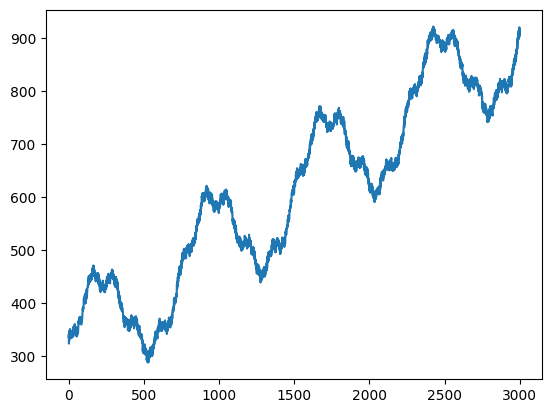

<class 'list'>


In [25]:
import random
from math import sin, cos
import matplotlib.pyplot as plt
import numpy as np


def get_time_series_data(length):
    a = .2
    b = 300
    c = 20
    ls = 5
    ms = 20
    gs = 100

    ts = []


    for i in range(length):
        ts.append(b + a * i + ls * sin(i / 5) + ms * cos(i / 24) + gs * sin(i / 120) + c * random.random())
        x = np.array(df_dl_p['Cost'].values)
        ts1 = np.concatenate((x, x), axis=0).tolist()

    #x = np.array(df_dl_p['Cost'].values)
    #np.concatenate((x, x, x, x), axis=0)
    #cost = np.concatenate((x, x, x, x, x, x, x, x, x, x), axis=0).tolist()
    #return cost

    return ts


if __name__ == '__main__':
    data = get_time_series_data(3_000)
    plt.plot(data)
    plt.show()
    print(type(data))

In [26]:
import torch

#from ch2.nn.time_series import get_time_series_data
from sklearn.model_selection import train_test_split


def get_time_series_datasets(features, ts_len):
    ts = get_time_series_data(ts_len)

    X = []
    Y = []
    for i in range(features + 1, ts_len):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i]])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, shuffle = False)

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [27]:
import torch
import torch.nn.functional as F

class FCNN(torch.nn.Module):

    def __init__(self, n_inp, l_1, l_2, n_out):
        super(FCNN, self).__init__()
        self.lin1 = torch.nn.Linear(n_inp, l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2, n_out)

    def forward(self, x):
        x1 = F.relu(self.lin1(x))
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y


In [28]:
class DummyPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            last_values.append([r[-1]])
        return torch.tensor(data = last_values)

In [29]:
from scipy import interpolate
import torch
import numpy as np


class InterpolationPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        values = x.tolist()
        for v in values:
            x = np.arange(0, len(v))
            y = interpolate.interp1d(x, v, fill_value = 'extrapolate')
            last_values.append([y(len(v)).tolist()])
        return torch.tensor(data = last_values)

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


class HwesPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r)
            results = model.fit()
            forecast = results.forecast()
            last_values.append([forecast[0]])
        return torch.tensor(data = last_values)

epoch 0: train - 287261.5938, val: - 468011.875
epoch 1000: train - 150.4284, val: - 147.0815
epoch 2000: train - 42.3347, val: - 42.962
epoch 3000: train - 37.5835, val: - 39.7382
epoch 4000: train - 106.1447, val: - 238.4097
epoch 5000: train - 35.128, val: - 38.1717
epoch 6000: train - 35.0077, val: - 38.0069
epoch 7000: train - 46.0955, val: - 43.2649
epoch 8000: train - 226.9768, val: - 392.9302
epoch 9000: train - 35.1323, val: - 41.6264
Testing
FCNN Loss: 38.02754211425781
Dummy Loss: 75.77690887451172
Linear Interpolation Loss: 220.05862426757812
HWES Loss: 59.23703327033799


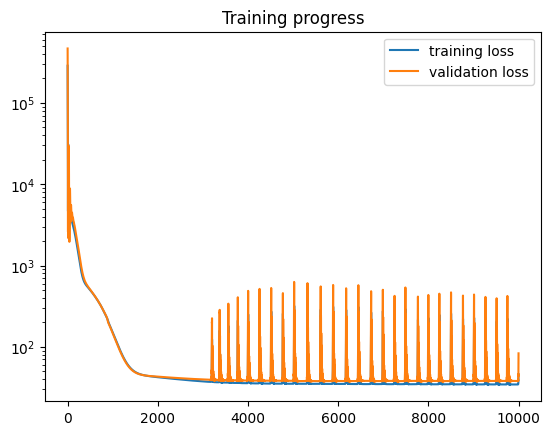

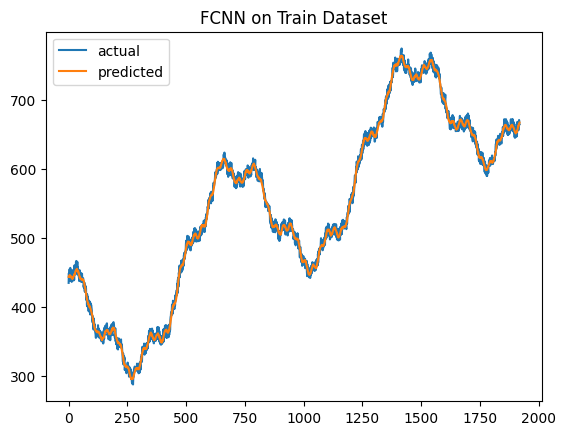

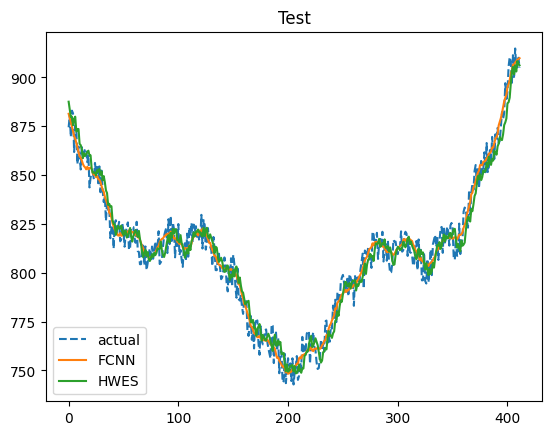

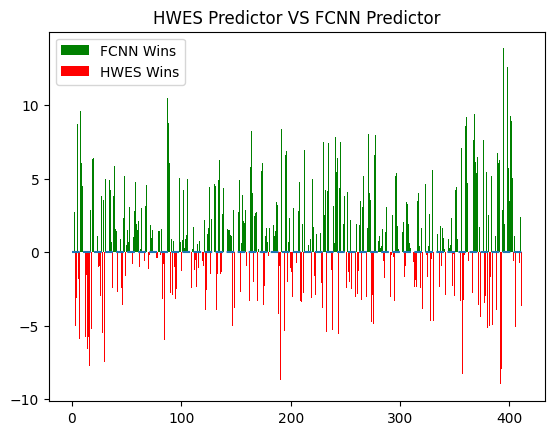

In [31]:
import copy
import random

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

#from ch2.nn.dataset import get_time_series_datasets
#from ch2.nn.dummy_model import DummyPredictor
#from ch2.nn.fcnn_model import FCNN
#from ch2.nn.hwes_model import HwesPredictor
#from ch2.nn.linear_interpolation_model import InterpolationPredictor

random.seed(1)
torch.manual_seed(1)

features = 256
ts_len = 3_000


#features = 8 # when using my data, I need to set this to 8, as the data has only 8 features
#ts_len = 42 # when using my data, I need to set this to 42, as the data has only 42 rows


x_train, x_val, x_test, y_train, y_val, y_test = get_time_series_datasets(features, ts_len)

net = FCNN(n_inp = features, l_1 = 64, l_2 = 32, n_out = 1)
net.train()
dummy_predictor = DummyPredictor()
interpolation_predictor = InterpolationPredictor()
hwes_predictor = HwesPredictor()

optimizer = torch.optim.Adam(params = net.parameters())
loss_func = torch.nn.MSELoss()

best_model = None
min_val_loss = 1_000_000

training_loss = []
validation_loss = []

for t in range(10_000):

    prediction = net(x_train)
    loss = loss_func(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction = net(x_val)
    val_loss = loss_func(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()

    if t % 1000 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, val: - {round(val_loss.item(), 4)}')

net.eval()

print('Testing')
print(f'FCNN Loss: {loss_func(best_model(x_test), y_test).item()}')
print(f'Dummy Loss: {loss_func(dummy_predictor(x_test), y_test).item()}')
print(f'Linear Interpolation Loss: {loss_func(interpolation_predictor(x_test), y_test).item()}')
print(f'HWES Loss: {loss_func(hwes_predictor(x_test), y_test).item()}')

plt.title("Training progress")
plt.yscale("log")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()

plt.title("FCNN on Train Dataset")
plt.plot(y_train, label = 'actual')
plt.plot(best_model(x_train).tolist(), label = 'predicted')
plt.legend()
plt.show()

plt.title('Test')
plt.plot(y_test, '--', label = 'actual')
plt.plot(best_model(x_test).tolist(), label = 'FCNN')
plt.plot(hwes_predictor(x_test).tolist(), label = 'HWES')
plt.legend()
plt.show()

test_n = len(y_test)
net_abs_dev = (best_model(x_test) - y_test).abs_()
hwes_abs_dev = (hwes_predictor(x_test) - y_test).abs_()
diff_pos = F.relu(hwes_abs_dev - net_abs_dev).reshape(test_n).tolist()
diff_min = (-F.relu(net_abs_dev - hwes_abs_dev)).reshape(test_n).tolist()
plt.title('HWES Predictor VS FCNN Predictor')
plt.hlines(0, xmin = 0, xmax = test_n, linestyles = 'dashed')
plt.bar(list(range(test_n)), diff_pos, color = 'g', label = 'FCNN Wins')
plt.bar(list(range(test_n)), diff_min, color = 'r', label = 'HWES Wins')
plt.legend()
plt.show()


# cahpter 3

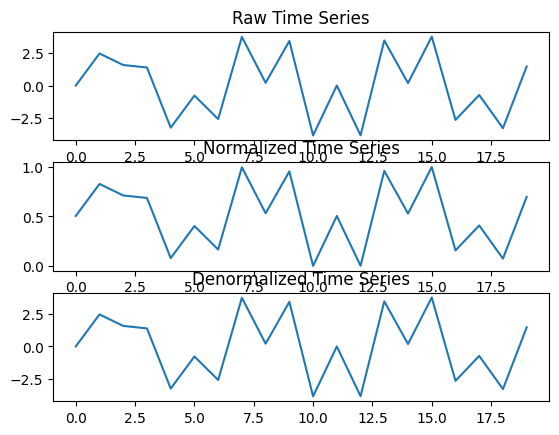

In [32]:
import random
from math import sin, cos
import matplotlib.pyplot as plt


def normalize(ts):
    max_ts = max(ts)
    min_ts = min(ts)
    normal_ts = [(v - min_ts) / (max_ts - min_ts) for v in ts]
    return normal_ts, max_ts, min_ts


def denormalize(ts, max_ts, min_ts):
    denormal_ts = [v * (max_ts - min_ts) + min_ts for v in ts]
    return denormal_ts


if __name__ == '__main__':

    random.seed(1)

    ts = [10 * sin(i) * cos(i) * cos(i) for i in range(20)]
    normal_ts, max_ts, min_ts = normalize(ts)
    denormal_ts = denormalize(normal_ts, max_ts, min_ts)

    fig = plt.figure()

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.set_title("Raw Time Series")
    ax1.plot(ts)

    ax2.set_title("Normalized Time Series")
    ax2.plot(normal_ts)

    ax3.set_title("Denormalized Time Series")
    ax3.plot(denormal_ts)

    plt.show()

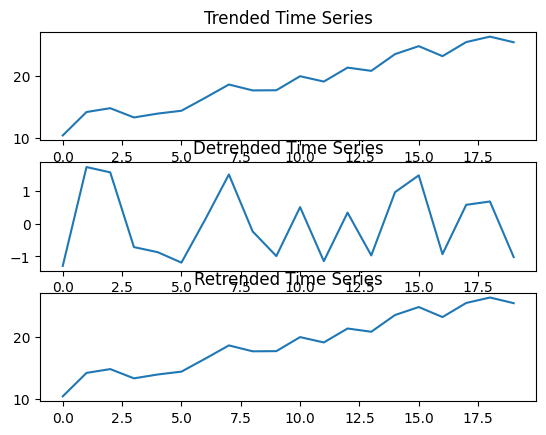

In [33]:
import random
from math import sin
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np


def detrend(ts):
    X = [[i] for i in range(len(ts))]
    y = np.array(ts).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    detrend_ts = [(ts[i] - a * i - b) for i in range(len(ts))]
    return detrend_ts, a, b


def retrend(ts, a, b):
    return [(ts[i] + a * i + b) for i in range(len(ts))]


if __name__ == '__main__':

    random.seed(1)

    ts = [10 + .8 * i + sin(i) + 3 * random.random() for i in range(20)]
    detrend_ts, a, b = detrend(ts)
    retrend_ts = retrend(detrend_ts, a, b)

    fig = plt.figure()

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.set_title("Trended Time Series")
    ax1.plot(ts)

    ax2.set_title("Detrended Time Series")
    ax2.plot(detrend_ts)

    ax3.set_title("Retrended Time Series")
    ax3.plot(retrend_ts)

    plt.show()


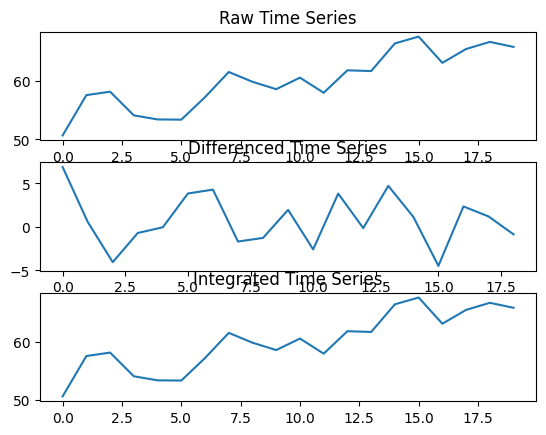

In [34]:
import random
from math import sin
import matplotlib.pyplot as plt


def differencing(ts):
    diff_ts = [(ts[i + 1] - ts[i]) for i in range(len(ts) - 1)]
    return diff_ts, ts[0]


def integration(ts, b):
    int_ts = [b]
    for i in range(len(ts)):
        int_ts.append(ts[i] + int_ts[i])
    return int_ts


if __name__ == '__main__':

    random.seed(1)

    ts = [50 + .8 * i + 3 * sin(i) + 5 * random.random() for i in range(20)]
    diff_ts, b = differencing(ts)
    int_ts = integration(diff_ts, b)

    fig = plt.figure()

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.set_title("Raw Time Series")
    ax1.plot(ts)

    ax2.set_title("Differenced Time Series")
    ax2.plot(diff_ts)

    ax3.set_title("Integrated Time Series")
    ax3.plot(int_ts)

    plt.show()


In [35]:
def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y


if __name__ == '__main__':
    ts = list(range(6))
    X, Y = sliding_window(ts, 3)

    print(f'Time series: {ts}')
    print(f'X: {X}')
    print(f'Y: {Y}')


Time series: [0, 1, 2, 3, 4, 5]
X: [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
Y: [[3], [4], [5]]


1680
Time series length: 1680
Time series: [379435.67704426637, 449911.8730518171, 464683.1307165075, 480684.4413508651, 495868.7747387589, 562230.9250019622, 646850.021354269, 1344621.5608610418, 706670.1739283177, 814895.0327967755, 628009.1186361226, 853861.6586929143, 633772.2923404174, 619883.3072291925, 889948.3509157086, 657555.1462692246, 612616.3813553966, 1637977.7237227731, 984951.6198149119, 661406.9150243629, 1430313.2300025013, 935199.4509987204, 561431.9740787416, 575917.7924029895, 605203.3199046137, 551499.4096732249, 1467498.8998575727, 810804.8344027712, 615822.8079764604, 989912.9216155177, 767211.2392779208, 754922.1798771931, 1542013.7530669936, 667258.506338098, 680725.6309697186, 1027314.5865055755, 660593.2724341612, 625740.6155318369, 1554001.9353160537, 956054.6327542005, 563596.494211636, 487636.7478748379, 379435.67704426637, 449911.8730518171, 464683.1307165075, 480684.4413508651, 495868.7747387589, 562230.9250019622, 646850.021354269, 1344621.5608610418, 

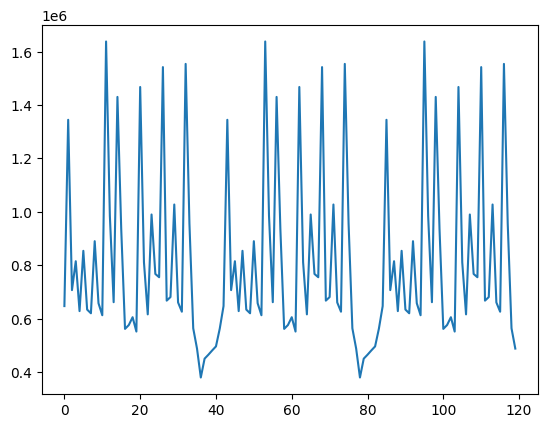

In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def interpolated_time_series():
    #dir_path = os.path.dirname(os.path.realpath(__file__)) # this is google Colab
    dir_path = path
    #ts_df = pd.read_csv(f'{dir_path}/data/MET_Office_Weather_Data.csv') # this is for google Colab
    ts_df = pd.read_csv("data/MET_Office_Weather_Data.csv") # this is for local
    
    ts = ts_df.loc[ts_df['station'] == 'sheffield']['tmin']\
        .interpolate().dropna().tolist()


    x = np.array(df_dl_p['Cost'].values)
    np.concatenate((x, x, x, x), axis=0)
    cost = np.concatenate((x, x, x, x, x, x, x, x, x, x,
                           x, x, x, x, x, x, x, x, x, x,
                           x, x, x, x, x, x, x, x, x, x,
                           x, x, x, x, x, x, x, x, x, x), axis=0).tolist()

    print(len(cost))
    ts = cost
    print(f'Time series length: {len(ts)}')
    print(f'Time series: {ts}')
    return ts


if __name__ == '__main__':
    ts = interpolated_time_series()
    plt.plot(ts[-120:])
    plt.show()


In [41]:
import torch

#from ch3.dataset.sliding_window import sliding_window
#from ch3.uk_temperature_prediction.interpolated_time_series import interpolated_time_series


def get_training_datasets(features, test_len):
    ts = interpolated_time_series()
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len], \
                                       Y[0:-test_len], \
                                       X[-test_len:], \
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test



In [42]:
import torch
import torch.nn.functional as F


class DL(torch.nn.Module):

    def __init__(self, n_inp, l_1, l_2, conv1_out, conv1_kernel, conv2_kernel, drop1 = 0):
        super(DL, self).__init__()
        conv1_out_ch = conv1_out
        conv2_out_ch = conv1_out * 2
        conv1_kernel = conv1_kernel
        conv2_kernel = conv2_kernel
        self.dropout_lin1 = drop1

        self.pool = torch.nn.MaxPool1d(kernel_size = 2)

        self.conv1 = torch.nn.Conv1d(in_channels = 1, out_channels = conv1_out_ch, kernel_size = conv1_kernel,
                                     padding = conv1_kernel - 1)

        self.conv2 = torch.nn.Conv1d(in_channels = conv1_out_ch, out_channels = conv2_out_ch,
                                     kernel_size = conv2_kernel,
                                     padding = conv2_kernel - 1)

        feature_tensor = self.feature_stack(torch.Tensor([[0] * n_inp]))
        self.lin1 = torch.nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2, 1)

    def feature_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        return x

    def fc_stack(self, x):
        x1 = F.dropout(F.relu(self.lin1(x)), p = self.dropout_lin1)
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y

    def forward(self, x):
        x = self.feature_stack(x)
        y = self.fc_stack(x)
        return y

In [43]:
net = DL(n_inp=120, l_1= 400, l_2= 48, conv1_out=6, conv1_kernel=36, conv2_kernel=12, drop1=0.1)

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch


class SarimaxPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        l = x.tolist()
        counter = 0
        for r in l:
            model = SARIMAX(r,
                            order = (1, 1, 1),
                            seasonal_order = (1, 1, 1, 12))
            results = model.fit(disp = 0)
            forecast = results.forecast()
            last_values.append([forecast[0]])
            counter = counter + 1
            print(f'debug: SARIMA calculation {counter} / {len(l)}')

        return torch.tensor(data = last_values)


In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import torch

class HwesPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r,
                                         trend = None,
                                         seasonal = "add",
                                         seasonal_periods = 12
                                         )
            results = model.fit()
            forecast = results.forecast()
            last_values.append([forecast[0]])
        return torch.tensor(data = last_values)

1680
Time series length: 1680
Time series: [379435.67704426637, 449911.8730518171, 464683.1307165075, 480684.4413508651, 495868.7747387589, 562230.9250019622, 646850.021354269, 1344621.5608610418, 706670.1739283177, 814895.0327967755, 628009.1186361226, 853861.6586929143, 633772.2923404174, 619883.3072291925, 889948.3509157086, 657555.1462692246, 612616.3813553966, 1637977.7237227731, 984951.6198149119, 661406.9150243629, 1430313.2300025013, 935199.4509987204, 561431.9740787416, 575917.7924029895, 605203.3199046137, 551499.4096732249, 1467498.8998575727, 810804.8344027712, 615822.8079764604, 989912.9216155177, 767211.2392779208, 754922.1798771931, 1542013.7530669936, 667258.506338098, 680725.6309697186, 1027314.5865055755, 660593.2724341612, 625740.6155318369, 1554001.9353160537, 956054.6327542005, 563596.494211636, 487636.7478748379, 379435.67704426637, 449911.8730518171, 464683.1307165075, 480684.4413508651, 495868.7747387589, 562230.9250019622, 646850.021354269, 1344621.5608610418, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization f

===
Results on Test Dataset
DL Loss: 18048.4551
SARIMA Loss: 208210.747
HWES Loss: 175713.349


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization f

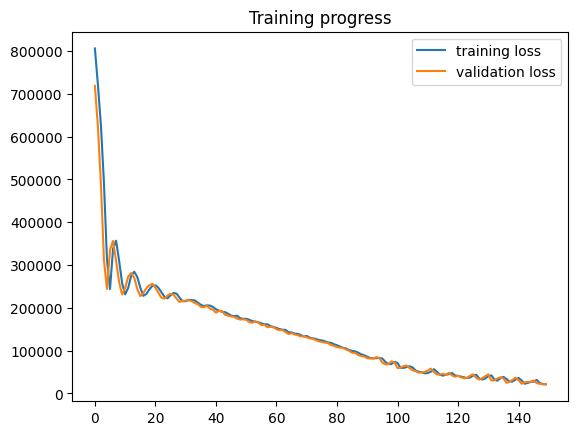

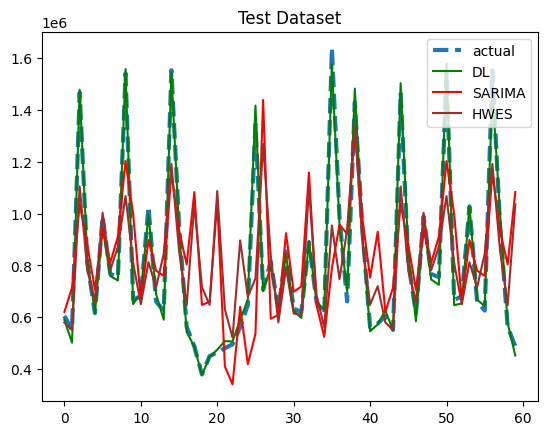

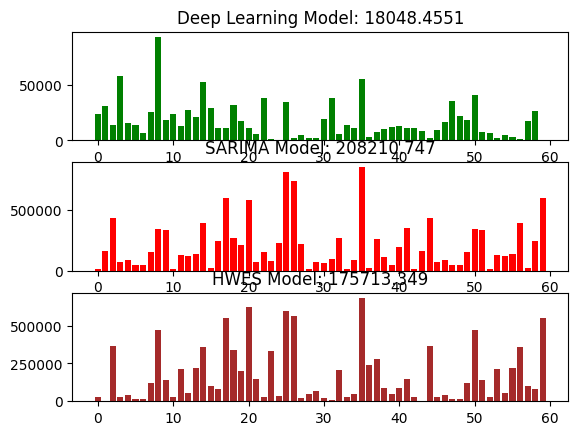

In [46]:
import copy
import random
import sys

import torch
import matplotlib.pyplot as plt

#from ch3.uk_temperature_prediction.model.dl_model import DL
#from ch3.uk_temperature_prediction.model.hwes_model import HwesPredictor
#from ch3.uk_temperature_prediction.model.sarima_model import SarimaxPredictor
#from ch3.uk_temperature_prediction.training_datasets import get_training_datasets

random.seed(1)
torch.manual_seed(1)

features = 120

x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(features, 60)

net = DL(
    n_inp = features,
    l_1 = 400,
    l_2 = 48,
    conv1_out = 6,
    conv1_kernel = 36,
    conv2_kernel = 12,
    drop1 = .1
)
net.train()

sarima_predictor = SarimaxPredictor()
hwes_predictor = HwesPredictor()

optimizer = torch.optim.Adam(params = net.parameters())
abs_loss = torch.nn.L1Loss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(150):

    prediction = net(x_train)
    loss = abs_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction = net(x_val)
    val_loss = abs_loss(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()

    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')

best_model.eval()

dl_prediction = best_model(x_test)
sarima_prediction = sarima_predictor(x_test)
hwes_prediction = hwes_predictor(x_test)

dl_abs_loss = round(abs_loss(dl_prediction, y_test).item(), 4)
sarima_abs_loss = round(abs_loss(sarima_prediction, y_test).item(), 4)
hwes_abs_loss = round(abs_loss(hwes_prediction, y_test).item(), 4)

print('===')
print('Results on Test Dataset')
print(f'DL Loss: {dl_abs_loss}')
print(f'SARIMA Loss: {sarima_abs_loss}')
print(f'HWES Loss: {hwes_abs_loss}')

plt.title("Training progress")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()

plt.title('Test Dataset')
plt.plot(y_test, '--', label = 'actual', linewidth = 3)
plt.plot(best_model(x_test).tolist(), label = 'DL', color = 'g')
plt.plot(sarima_prediction.tolist(), label = 'SARIMA', color = 'r')
plt.plot(hwes_prediction.tolist(), label = 'HWES', color = 'brown')
plt.legend()
plt.show()

test_n = len(y_test)
dl_abs_dev = (dl_prediction - y_test).abs_()
sarima_abs_dev = (sarima_prediction - y_test).abs_()
hwes_abs_dev = (hwes_prediction - y_test).abs_()

fig = plt.figure()

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.set_title(f'Deep Learning Model: {dl_abs_loss}')
ax1.bar(list(range(test_n)), dl_abs_dev.view(test_n).tolist(), color = 'g')

ax2.set_title(f'SARIMA Model: {sarima_abs_loss}')
ax2.bar(list(range(test_n)), sarima_abs_dev.view(test_n).tolist(), color = 'r')

ax3.set_title(f'HWES Model: {hwes_abs_loss}')
ax3.bar(list(range(test_n)), hwes_abs_dev.view(test_n).tolist(), color = 'brown')

plt.show()


# end of Chapter 3

In [15]:
x = np.array(df_dl_p['Cost'].values)
np.concatenate((x, x, x, x), axis=0)
cost = np.concatenate((x, x, x, x, x, x, x, x, x, x), axis=0).tolist()
print(len(cost))

420


# Chapter 4 - RNN (Recurrent Neural Netowrks)

In [49]:
import os
print(os.getcwd())
print("__file__: " + os.getcwd())
print("realpath: " + os.getcwd())

/Users/jorgerodriguez/Documents/GitHub/AWS_FinOps/FinOps_AWS
__file__: /Users/jorgerodriguez/Documents/GitHub/AWS_FinOps/FinOps_AWS
realpath: /Users/jorgerodriguez/Documents/GitHub/AWS_FinOps/FinOps_AWS


In [66]:
import os

import pandas as pd
import torch


def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y


def get_aep_timeseries():
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.getcwd()
    df = pd.read_csv(f'{dir_path}/data/AEP_hourly.csv')
    ts = df['AEP_MW'].astype(int).values.reshape(-1, 1)[-3000:]

    #x = (df_dl_p['Cost'].astype(int).values.reshape(-1, 1)[-12:])
    #ts = x
    #np.concatenate((x, x, x, x), axis=0)
    #cost = np.concatenate((x, x, x, x, x, x, x, x, x, x,
    #                       x, x, x, x, x, x, x, x, x, x,
    #                       x, x, x, x, x, x, x, x, x, x,
    #                       x, x, x, x, x, x, x, x, x, x), axis=0).tolist()

    #print(len(cost))
    #ts = cost.reshape(-1, 1)[-100:]
    return ts


def get_pjme_timeseries():
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.getcwd()
    df = pd.read_csv(f'{dir_path}/data/PJME_hourly.csv')
    ts = df['PJME_MW'].astype(int).values.reshape(-1, 1)[-3000:]
    return ts


def get_ni_timeseries():
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.getcwd()
    df = pd.read_csv(f'{dir_path}/data/NI_hourly.csv')
    ts = df['NI_MW'].astype(int).values.reshape(-1, 1)[-3000:]
    return ts


def get_training_datasets(ts, features, test_len):
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len],\
                                       Y[0:-test_len],\
                                       X[-test_len:],\
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train).float()
    y_train = torch.tensor(data = Y_train).float()

    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()

    x_test = torch.tensor(data = X_test).float()
    y_test = torch.tensor(data = Y_test).float()

    return x_train, x_val, x_test,\
           y_train.squeeze(1), y_val.squeeze(1), y_test.squeeze(1)


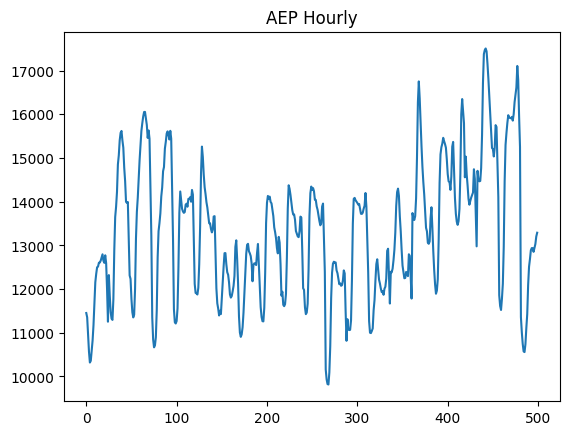

In [67]:
import matplotlib.pyplot as plt
#from ch4.training_datasets import get_aep_timeseries

get_aep_timeseries()
plt.title('AEP Hourly')
plt.plot(get_aep_timeseries()[:500])
plt.show()

In [55]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h = None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

epoch 0: train - 0.377, val: - 0.0866
epoch 50: train - 0.0061, val: - 0.0133
epoch 100: train - 0.0021, val: - 0.0044
epoch 150: train - 0.0018, val: - 0.0034
epoch 200: train - 0.0015, val: - 0.003
epoch 250: train - 0.0014, val: - 0.0027
epoch 300: train - 0.0013, val: - 0.0026
epoch 350: train - 0.0012, val: - 0.0025
epoch 400: train - 0.0012, val: - 0.0024
epoch 450: train - 0.0012, val: - 0.0024


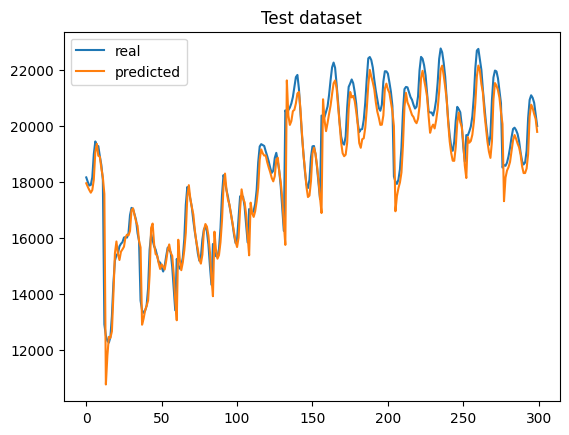

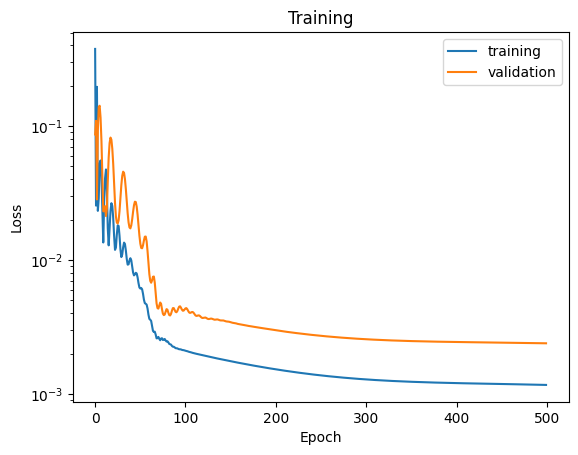

In [68]:
import copy
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
#from ch4.model.rnn import RNN
#from ch4.training_datasets import get_training_datasets, get_aep_timeseries

random.seed(1)
torch.manual_seed(1)

# PARAMETERS

# length of sliding window
features = 240
# length of test dataset
test_ts_len = 300
# size of RNN hidden state
rnn_hidden_size = 24
# Optimizer learning rate
learning_rate = 0.02

training_epochs = 500

# Preparing datasets for Training
ts = get_aep_timeseries()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(scaled_ts, features, test_ts_len)

# Initializing the model
model = RNN(hidden_size = rnn_hidden_size)
model.train()

# Training
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):

    prediction, _ = model(x_train)
    loss = mse_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 50 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')

best_model.eval()
_, h_list = best_model(x_val)
# warm hidden state
h = (h_list[-1, :]).unsqueeze(-2)

predicted = []
for test_seq in x_test.tolist():
    x = torch.Tensor(data = [test_seq])
    # passing hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2))
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    predicted.append(unscaled)

real = scaler.inverse_transform(y_test.tolist())
plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(predicted, label = 'predicted')
plt.legend()
plt.show()

plt.title('Training')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Chapter 5
# TCN - Temporal Convolutional Network